In [21]:
from __future__ import division
from math import *
import numpy as np
import sys
import os
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterExponent
from matplotlib.ticker import LogFormatterSciNotation

import pandas as pd
import numpy as np
import matplotlib, os
import matplotlib.pyplot as plt
# Matplotlib configuration
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.style.use('classic')
plt.rcParams['xtick.direction']     = 'in'
plt.rcParams['ytick.direction']     = 'in'
plt.rcParams['xtick.top']           = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.right']         = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import matplotlib.cm as cm

from matplotlib import pyplot
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family' : "sans-serif"})
params= {'text.latex.preamble' : [r'\usepackage{amssymb}']}
pyplot.rcParams.update(params)

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import griddata
from scipy.interpolate import interp1d

import sys
sys.path.append("/Users/oozdal/packages/ma5-histo")
sys.path.append("/Users/oozdal/packages/ma5_expert")

import src.SafReader as sr
from CutFlowReader import Collection

In [22]:
def df(fileLoc):
    data = sr.read(fileLoc=fileLoc)
    floatCols=['binMin', 'binMax', 'value']
    data[floatCols]  = data[floatCols].apply(pd.to_numeric, errors='coerce')
    data["bin"]      = (data.binMin+data.binMax)/2
    data             = data[data.binMax != np.inf]
    data             = data[data.binMin != -1*np.inf]
    data["binlabel"] = (data.binMin+data.binMax)/2
    return data

In [23]:
def unc(observable, Nevt):
    return np.sqrt((1-observable**2)/Nevt)

def sig(O1, O2, Nevt1, Nevt2):
    return abs(O1-O2)/np.sqrt( unc(O2,Nevt2)**2 )  #+ unc(O1,Nevt1)**2 )

In [24]:
lumi=3000.

# Standard Model 

In [25]:
AFB_data = '/Users/oozdal/projects/SSM_WpZp/AFB_data'

SM = Collection(collection_path= AFB_data+'/SMll_Mll4500and8000/MadAnalysis5job_0/Cutflows',
                    saf_file       = AFB_data+'/SMll_Mll4500and8000/SMll_Mll4500and8000.saf',
                    lumi           = 3000.)
SM_RapNo_sumw  = SM['Rap_No'][0].sumw
SM_Rap00_sumw  = SM['Rap_00'][0].sumw
SM_Rap02_sumw  = SM['Rap_02'][0].sumw
SM_Rap04_sumw  = SM['Rap_04'][0].sumw
SM_histos = df(AFB_data+'/SMll_Mll4500and8000/MadAnalysis5job_0/Histograms/histos.saf')

In [26]:
SM_df = pd.read_csv('/Users/oozdal/projects/SSM_WpZp/AFB_data/SM.csv', header=0, sep=",")
SM_df.columns = ["Mll", "angle_CM_true", "angle_CM_rec", "cos_angle_CM_star", "Eta_lp", "Eta_lm", "Mll_Boosted", "Eta_Boosted_lp", "Eta_Boosted_lm", "quarkcharge",
"Lepton_Charge","yll_lab", "yll_CM","EvWeight"]

Let's apply some bounds

In [27]:
SM_df = SM_df[ (SM_df["Mll"] >= 5400.)  & (SM_df["Mll"] <= 6600.) ]      # Mll [5-6] TeV
SM_df = SM_df[ (SM_df["Eta_lp"] <= 2.5) & (SM_df["Eta_lm"] <= 2.5) ]     # Eta(lepton) < 2.5

SM_df_NegLep = SM_df[ (SM_df["Lepton_Charge"] < 0.) ]  # We will compute AFB using negatively charged leptons. Therefore we don't need positive leptons! 

# True AFB Components for the SM

In [28]:
SM_AFB_pos = SM_df_NegLep[ np.cos(SM_df_NegLep["angle_CM_true"]) > 0. ]
SM_AFB_neg = SM_df_NegLep[ np.cos(SM_df_NegLep["angle_CM_true"]) < 0. ]

BinNumber = 24
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

    
TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []


i=0
for i in range(len(bins)-1):
    Box_LepPos = SM_AFB_pos[:][ (SM_AFB_pos["Mll"]>bins[i]) & (SM_AFB_pos["Mll"]<bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = SM_AFB_neg[:][ (SM_AFB_neg["Mll"]>bins[i]) & (SM_AFB_neg["Mll"]<bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AFB_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AFB_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

AFB_SM     = AFB_num/np.where(AFB_den==0,1e10,AFB_den)
print(AFB_SM)

#Number of Events
NumofEvents_LepPos_SM = TotEvWeight_LepPos_Arr2*lumi*SM.xsec*1000/SM_RapNo_sumw
NumofEvents_LepNeg_SM = TotEvWeight_LepNeg_Arr2*lumi*SM.xsec*1000/SM_RapNo_sumw

[0.59433124 0.598967   0.60083503 0.60121677 0.60174365 0.59897246
 0.59562304 0.60050983 0.60100638 0.59316952 0.60336167 0.6028439
 0.59491567 0.59549924 0.59407498 0.59868284 0.59450001 0.60376331
 0.6010472  0.59958602 0.59655604 0.59769167 0.58618394 0.60481169]


# Reconstructed AFB Components for the SM (yll > 0)

In [29]:
#SM_df_NegLep = SM_df_NegLep[ np.abs(SM_df_NegLep["yll_lab"]) > 0. ]
#SM_df = SM_df[ (SM_df["Lepton_Charge"] < 0.) ]

RecSM_AFB_pos_Rap00 = SM_df[ np.sign(SM_df["yll_lab"]) != np.sign(SM_df["Eta_Boosted_lm"]) ]
RecSM_AFB_neg_Rap00 = SM_df[ np.sign(SM_df["yll_lab"]) == np.sign(SM_df["Eta_Boosted_lm"]) ]

#RecSM_AFB_pos_Rap00 = SM_df[ SM_df["cos_angle_CM_star"] < 0. ]
#RecSM_AFB_neg_Rap00 = SM_df[ SM_df["cos_angle_CM_star"] > 0. ]

#RecSM_AFB_pos_Rap00 = SM_df_NegLep[ np.cos(SM_df_NegLep["angle_CM_true"]) > 0. ]
#RecSM_AFB_pos_Rap00 = SM_df_NegLep[ np.cos(SM_df_NegLep["angle_CM_true"]) < 0. ]


BinNumber = 24
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)
    
TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []

i=0
for i in range(len(bins)-1):
    Box_LepPos = RecSM_AFB_pos_Rap00[:][ (RecSM_AFB_pos_Rap00["Mll"]>bins[i]) & (RecSM_AFB_pos_Rap00["Mll"]<bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = RecSM_AFB_neg_Rap00[:][ (RecSM_AFB_neg_Rap00["Mll"]>bins[i]) & (RecSM_AFB_neg_Rap00["Mll"]<bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AFB_num = TotEvWeight_LepPos_Arr2 - TotEvWeight_LepNeg_Arr2
AFB_den = TotEvWeight_LepPos_Arr2 + TotEvWeight_LepNeg_Arr2

######################### Output ######################################

# Reconstructed AFB
RecAFB_SM_Rap00     = AFB_num/np.where(AFB_den==0,1e10,AFB_den)
print(RecAFB_SM_Rap00)

#Number of Events
NumofEvents_LepPos_SM_Rap00 = TotEvWeight_LepPos_Arr2*lumi*SM.xsec*1000/SM_Rap00_sumw
NumofEvents_LepNeg_SM_Rap00 = TotEvWeight_LepNeg_Arr2*lumi*SM.xsec*1000/SM_Rap00_sumw


[0.10440196 0.11385675 0.12094576 0.12921309 0.14114244 0.1390876
 0.15052631 0.15498536 0.15843451 0.16822081 0.17614037 0.18702889
 0.1827266  0.18620781 0.19736013 0.20786922 0.21144235 0.21218027
 0.22464146 0.22757564 0.22467036 0.23145074 0.23737976 0.23602322]


# Reconstructed AFB Components for the SM (yll > 0.2)

In [30]:
SM_df = SM_df[ abs(SM_df["yll_lab"]) > 0.2 ]

RecSM_AFB_pos_Rap02 = SM_df[ np.sign(SM_df["yll_lab"]) != np.sign(SM_df["Eta_Boosted_lm"]) ]
RecSM_AFB_neg_Rap02 = SM_df[ np.sign(SM_df["yll_lab"]) == np.sign(SM_df["Eta_Boosted_lm"]) ]


BinNumber = 24
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)
    
TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []

i=0
for i in range(len(bins)-1):
    Box_LepPos = RecSM_AFB_pos_Rap02[:][ (RecSM_AFB_pos_Rap02["Mll"]>bins[i]) & (RecSM_AFB_pos_Rap02["Mll"]<bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = RecSM_AFB_neg_Rap02[:][ (RecSM_AFB_neg_Rap02["Mll"]>bins[i]) & (RecSM_AFB_neg_Rap02["Mll"]<bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AFB_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AFB_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

######################### Output ######################################

# Reconstructed AFB
RecAFB_SM_Rap02     = AFB_num/np.where(AFB_den==0,1e10,AFB_den)
print(RecAFB_SM_Rap02)

#Number of Events
NumofEvents_LepPos_SM_Rap02 = TotEvWeight_LepPos_Arr2*lumi*SM.xsec*1000/SM_Rap02_sumw
NumofEvents_LepNeg_SM_Rap02 = TotEvWeight_LepNeg_Arr2*lumi*SM.xsec*1000/SM_Rap02_sumw

[0.14736243 0.15755251 0.17260108 0.18008404 0.19561623 0.19212195
 0.20428802 0.21441681 0.22132254 0.23224843 0.23971023 0.25708411
 0.24964368 0.26114997 0.27580141 0.28156656 0.28213781 0.29302043
 0.31369019 0.32219989 0.31603558 0.32363636 0.32642131 0.32508073]


# Sequential Standard Model

In [31]:
AFB_data = '/Users/oozdal/projects/SSM_WpZp/AFB_data'

SSM = Collection(collection_path= AFB_data+'/SeqSMll_LO/MadAnalysis5job_0/Cutflows',
                    saf_file       = AFB_data+'/SeqSMll_LO/SeqSMll_LO.saf',
                    lumi           = 3000.)
SSM_sumw   = SSM['Rap_No'][0].sumw
SSM_Rap00_sumw = SSM['Rap_00'][0].sumw
SSM_Rap02_sumw = SSM['Rap_02'][0].sumw
SSM_histos = df(AFB_data+'/SeqSMll_LO/MadAnalysis5job_0/Histograms/histos.saf')

In [32]:
SSM_df = pd.read_csv('/Users/oozdal/projects/SSM_WpZp/AFB_data/SeqSM.csv', header=0, sep=",")
SSM_df.columns = ["Mll", "angle_CM_true", "angle_CM_rec", "cos_angle_CM_star", "Eta_lp", "Eta_lm", "Mll_Boosted", "Eta_Boosted_lp", "Eta_Boosted_lm", "quarkcharge",
"Lepton_Charge","yll_lab", "yll_CM","EvWeight"]

#SSM_df = SSM_df.head(100000)

Let's apply some bounds

In [33]:
SSM_df = SSM_df[ (SSM_df["Mll"] >= 5400.)  & (SSM_df["Mll"] <= 6600.) ]   # Mll [5-6] TeV
SSM_df = SSM_df[ (SSM_df["Eta_lp"] <= 2.5) & (SSM_df["Eta_lm"] <= 2.5) ]  # Eta(lepton) < 2.5
SSM_df_NegLep = SSM_df[ (SSM_df["Lepton_Charge"] < 0.) ]    # We will compute AFB using negatively charged leptons. Therefore we don't need positive leptons! 

# True AFB Components for Sequential Standard Model

In [34]:
SSM_AFB_pos = SSM_df_NegLep[ np.cos(SSM_df_NegLep["angle_CM_true"]) > 0. ]
SSM_AFB_neg = SSM_df_NegLep[ np.cos(SSM_df_NegLep["angle_CM_true"]) < 0. ]

BinNumber = 24
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

    
TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []


i=0
for i in range(len(bins)-1):
    Box_LepPos = SSM_AFB_pos[:][ (SSM_AFB_pos["Mll"]>bins[i]) & (SSM_AFB_pos["Mll"]<bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = SSM_AFB_neg[:][ (SSM_AFB_neg["Mll"]>bins[i]) & (SSM_AFB_neg["Mll"]<bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AFB_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AFB_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

AFB_SSM     = AFB_num/np.where(AFB_den==0,1e10,AFB_den)

#Number of Events
NumofEvents_LepPos_SSM = TotEvWeight_LepPos_Arr2*lumi*SSM.xsec*1000/SSM_sumw
NumofEvents_LepNeg_SSM = TotEvWeight_LepNeg_Arr2*lumi*SSM.xsec*1000/SSM_sumw

# Reconstructed AFB Components for the Sequential SM (yll > 0.)

In [35]:
SSM_df = SSM_df[ np.abs(SSM_df["yll_lab"]) > 0.0 ]


RecSSM_AFB_pos_Rap00 = SSM_df[ np.sign(SSM_df["yll_lab"]) != np.sign(SSM_df["Eta_Boosted_lm"]) ]
RecSSM_AFB_neg_Rap00 = SSM_df[ np.sign(SSM_df["yll_lab"]) == np.sign(SSM_df["Eta_Boosted_lm"]) ]

BinNumber = 24
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

    
TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []


i=0
for i in range(len(bins)-1):
    Box_LepPos = RecSSM_AFB_pos_Rap00[:][ (RecSSM_AFB_pos_Rap00["Mll"]>bins[i]) & (RecSSM_AFB_pos_Rap00["Mll"]<bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = RecSSM_AFB_neg_Rap00[:][ (RecSSM_AFB_neg_Rap00["Mll"]>bins[i]) & (RecSSM_AFB_neg_Rap00["Mll"]<bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AFB_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AFB_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

######################### Ouput ######################################

# Reconstructed AFB
RecAFB_SSM_Rap00     = AFB_num/np.where(AFB_den==0,1e10,AFB_den)
print(RecAFB_SSM_Rap00)

#Number of Events
NumofEvents_LepPos_SSM_Rap00 = TotEvWeight_LepPos_Arr2*lumi*SSM.xsec*1000/SSM_Rap00_sumw
NumofEvents_LepNeg_SSM_Rap00 = TotEvWeight_LepNeg_Arr2*lumi*SSM.xsec*1000/SSM_Rap00_sumw

[-0.05699934 -0.0640173  -0.05744059 -0.05101006 -0.04765354 -0.03599902
 -0.02007518 -0.02039143 -0.00709483 -0.00031274  0.01439356  0.02402775
  0.03443474  0.04310553  0.05247071  0.06330833  0.07712841  0.08381112
  0.09497611  0.10060475  0.11482216  0.11986699  0.13487051  0.13309047]


# Reconstructed AFB Components for the Sequential SM (yll > 0.2)

In [36]:
SSM_df = SSM_df[ np.abs(SSM_df["yll_lab"]) > 0.2 ]


RecSSM_AFB_pos_Rap02 = SSM_df[ np.sign(SSM_df["yll_lab"]) != np.sign(SSM_df["Eta_Boosted_lm"]) ]
RecSSM_AFB_neg_Rap02 = SSM_df[ np.sign(SSM_df["yll_lab"]) == np.sign(SSM_df["Eta_Boosted_lm"]) ]

BinNumber = 24
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

    
TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []


i=0
for i in range(len(bins)-1):
    Box_LepPos = RecSSM_AFB_pos_Rap02[:][ (RecSSM_AFB_pos_Rap02["Mll"]>bins[i]) & (RecSSM_AFB_pos_Rap02["Mll"]<bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = RecSSM_AFB_neg_Rap02[:][ (RecSSM_AFB_neg_Rap02["Mll"]>bins[i]) & (RecSSM_AFB_neg_Rap02["Mll"]<bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AFB_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AFB_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

######################### Ouput ######################################

# Reconstructed AFB
RecAFB_SSM_Rap02     = AFB_num/np.where(AFB_den==0,1e10,AFB_den)
print(RecAFB_SSM_Rap02)

#Number of Events
NumofEvents_LepPos_SSM_Rap02 = TotEvWeight_LepPos_Arr2*lumi*SSM.xsec*1000/SSM_Rap02_sumw
NumofEvents_LepNeg_SSM_Rap02 = TotEvWeight_LepNeg_Arr2*lumi*SSM.xsec*1000/SSM_Rap02_sumw

[-0.09141192 -0.09747104 -0.08824183 -0.07765331 -0.06732331 -0.05467145
 -0.03613535 -0.0290367  -0.01439045 -0.0050605   0.01586102  0.02921797
  0.04418738  0.05767253  0.07230881  0.08738968  0.10703727  0.11525544
  0.13153625  0.14350009  0.15085889  0.16033633  0.17913109  0.2002793 ]


# AFB Plotting for Sequential Standard Model

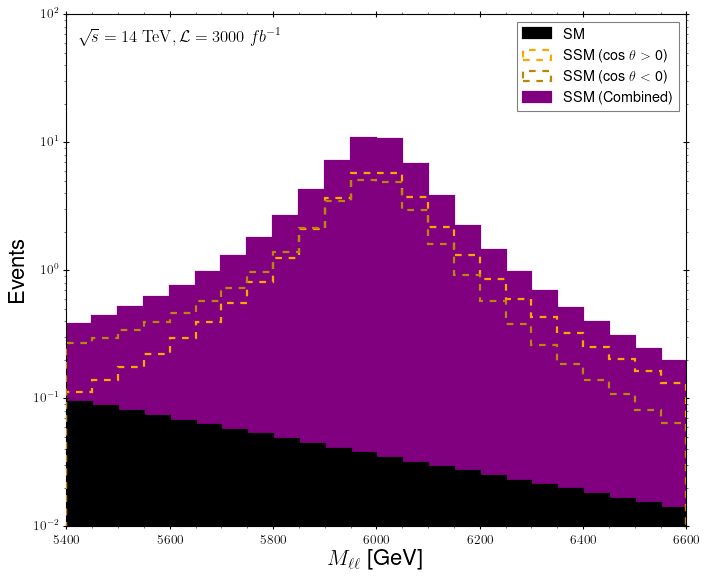

In [46]:
pyplot.rcParams['figure.figsize'] = (10.0, 8.0)
#fig.suptitle(r'No $y_{\ell \ell}$ Cut', fontsize=40)

BinNumber = 24
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

binlabel = []
i=0
for i in range(len(bins)-1):
    binlabel.append((bins[i]+bins[i+1])/2.)


fig, ax1 = plt.subplots()
fig.set_facecolor('white')
#plt.title(r"$E_6 - \psi$ Model", fontsize=20)
plt.hist(binlabel,bins=bins,
             label=r'SM', histtype="stepfilled", rwidth=1.0,
             weights=NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM, facecolor="black",
             color=None, edgecolor='black', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=5)
plt.hist(binlabel,bins=bins,
             label=r'SSM (cos $\theta > $ 0)', histtype="step", rwidth=1.0,
             weights=NumofEvents_LepPos_SSM, facecolor="orange",
             color=None, edgecolor='orange', linewidth=2, linestyle="dashed",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=7)
plt.hist(binlabel,bins=bins,
             label=r'SSM (cos $\theta < $ 0)', histtype="step", rwidth=1.0,
             weights=NumofEvents_LepNeg_SSM, facecolor="darkgoldenrod",
             color=None, edgecolor='darkgoldenrod', linewidth=2, linestyle="dashed",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=8)
plt.hist(binlabel,bins=bins,
             label=r'SSM (Combined)', histtype="stepfilled", rwidth=1.0,
             weights=NumofEvents_LepPos_SSM+NumofEvents_LepNeg_SSM, facecolor="purple",
             color=None, edgecolor='purple', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)
plt.xlabel(r' $M_{\ell \ell}$ [GeV]' , fontsize=20)
plt.ylabel('Events' , fontsize=20)
#plt.xscale('log')
plt.yscale('log')

ax1.text(5425, 60, r"$\displaystyle \sqrt{s} = 14 {\rm\ TeV}, \mathcal{L} = 3000\ fb^{-1}$", size=15)


leg = ax1.legend(loc='upper right',fontsize=13) #,ncol=2)#,framealpha=.5)#.get_lines().set_linewidth(0.)
leg.get_frame().set_alpha(0.5)
#leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
ax1.set_xlim([min(bins),max(bins)])
#ax1.set_ylim([1e-4,1e1])
ax1.tick_params(axis="x", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(axis="y", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(which="minor", axis="x", direction="out")
ax1.tick_params(which="minor", axis="y", direction="out")

fig.savefig('/Users/oozdal/Dropbox/WpZp_Project/Results/Ozer/Mll_SSM.png')
plt.show()

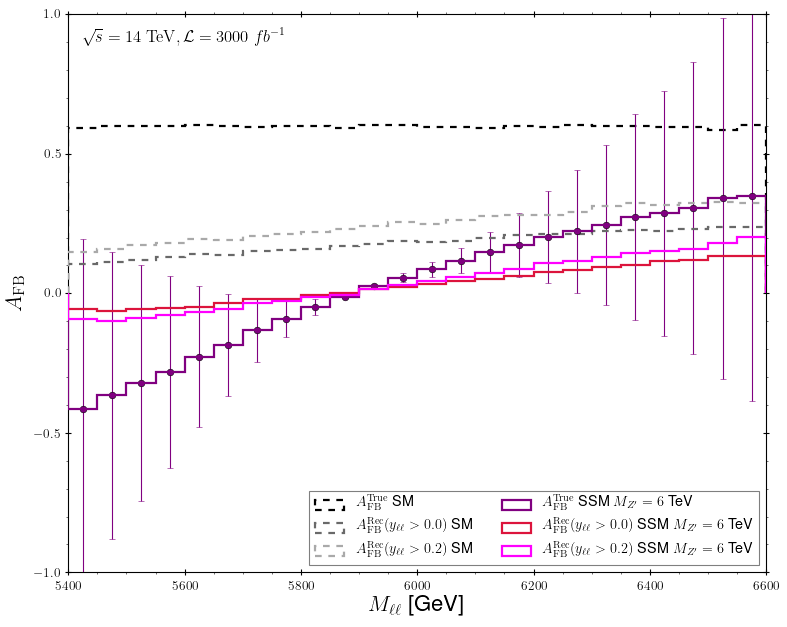

In [45]:
pyplot.rcParams['figure.figsize'] = (10.0, 8.0)
#fig.suptitle(r'No $y_{\ell \ell}$ Cut', fontsize=40)

BinNumber = 24
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

binlabel = []
i=0
for i in range(len(bins)-1):
    binlabel.append((bins[i]+bins[i+1])/2.)


#fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [4, 1]})
fig, ax1 = plt.subplots(1)
fig.set_facecolor('white')
#plt.title(r"$E_6 - \eta$ Model", fontsize=20)


ax1.hist(binlabel,bins=bins,
             label=r"$A_{\rm FB}^{\rm True}$ SM", histtype="step", rwidth=1.0,
             weights=AFB_SM, facecolor="black",
             color=None, edgecolor='black', linewidth=2, linestyle="dashed",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)

ax1.hist(binlabel,bins=bins,
             label=r"$A_{\rm FB}^{\rm Rec} (y_{\ell \ell}>0.0) $ SM", histtype="step", rwidth=1.0,
             weights=RecAFB_SM_Rap00, facecolor="dimgray",
             color=None, edgecolor='dimgray', linewidth=2, linestyle="dashed",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=2)

ax1.hist(binlabel,bins=bins,
             label=r"$A_{\rm FB}^{\rm Rec} (y_{\ell \ell}>0.2) $ SM", histtype="step", rwidth=1.0,
             weights=RecAFB_SM_Rap02, facecolor="darkgray",
             color=None, edgecolor='darkgray', linewidth=2, linestyle="dashed",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=3)


ax1.hist(binlabel,bins=bins,
             label=r"$A_{\rm FB}^{\rm True}$ SSM $M_{Z^\prime} = 6$ TeV", histtype="step", rwidth=1.0,
             weights=AFB_SSM, facecolor="purple",
             color=None, edgecolor='purple', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=4)


ax1.hist(binlabel,bins=bins,
             label=r"$A_{\rm FB}^{\rm Rec} (y_{\ell \ell}>0.0)$  SSM $M_{Z^\prime} = 6$ TeV", histtype="step", rwidth=1.0,
             weights=RecAFB_SSM_Rap00, facecolor="crimson",
             color=None, edgecolor='crimson', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=5)

ax1.hist(binlabel,bins=bins,
             label=r"$A_{\rm FB}^{\rm Rec} (y_{\ell \ell}>0.2)$  SSM $M_{Z^\prime} = 6$ TeV", histtype="step", rwidth=1.0,
             weights=RecAFB_SSM_Rap02, facecolor="magenta",
             color=None, edgecolor='magenta', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=6)

#ax1.errorbar(binlabel, AFB_SM, yerr=AFB_SM*unc(AFB_SM,NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM), linestyle='None', marker='o')
ax1.errorbar(binlabel, AFB_SSM, yerr=AFB_SSM*unc(AFB_SSM,(NumofEvents_LepPos_SSM+NumofEvents_LepNeg_SSM)), linestyle='None', marker='o', color='purple')

#ax1.set_xlabel(r' $M_{\ell \ell}$ [GeV]' , fontsize=20)
ax1.set_ylabel(r'$A_{\rm FB}$' , fontsize=20)
#ax1.set_yscale('log')

ax1.text(5425, 0.90, r"$\displaystyle \sqrt{s} = 14 {\rm\ TeV}, \mathcal{L} = 3000\ fb^{-1}$", size=15)

leg = ax1.legend(loc='lower right',fontsize=13,ncol=2)#,framealpha=.5)#.get_lines().set_linewidth(0.)
leg.get_frame().set_alpha(0.5)
#leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
ax1.set_xlim([min(bins),max(bins)])
ax1.set_ylim([-1.0,1.0])
ax1.tick_params(axis="x", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(axis="y", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(which="minor", axis="x", direction="out")
ax1.tick_params(which="minor", axis="y", direction="out")


#ax2.hist(binlabel,bins=bins,
#             label=r'SSM (Combined)', histtype="step", rwidth=1.0,
#             weights=sig(AFB_SM, AFB_SSM, (NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM), (NumofEvents_LepPos_SSM+NumofEvents_LepNeg_SSM)), facecolor="purple",
#             color=None, edgecolor='purple', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)

#ax2.hist(binlabel,bins=bins,
#             label=r'SSM (Combined)', histtype="step", rwidth=1.0,
#             weights=sig(RecAFB_SM_Rap00, RecAFB_SSM_Rap00, (NumofEvents_LepPos_SM_Rap00+NumofEvents_LepNeg_SM_Rap00), (NumofEvents_LepPos_SSM_Rap00+NumofEvents_LepNeg_SSM_Rap00)), facecolor="purple",
#             color=None, edgecolor='crimson', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1, alpha=0.7)


#ax2.hist(binlabel,bins=bins,
#             label=r'SSM (Combined)', histtype="step", rwidth=1.0,
#             weights=sig(RecAFB_SM_Rap02, RecAFB_SSM_Rap02, (NumofEvents_LepPos_SM_Rap02+NumofEvents_LepNeg_SM_Rap02), (NumofEvents_LepPos_SSM_Rap02+NumofEvents_LepNeg_SSM_Rap02)), facecolor="purple",
#             color=None, edgecolor='magenta', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=2, alpha=0.7)

#ax2.errorbar(binlabel, sig(AFB_SM, AFB_SSM, (NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM), (NumofEvents_LepPos_SSM+NumofEvents_LepNeg_SSM)), 
#             yerr=AFB_SSM*unc(AFB_SSM,(NumofEvents_LepPos_SSM+NumofEvents_LepNeg_SSM)), linestyle='None', marker='o', color='purple')
#ax2.set_ylim([0,2.0])

ax1.set_xlabel(r' $M_{\ell \ell}$ [GeV]' , fontsize=20)
#ax1.set_ylabel(r'Significance' , fontsize=15)

fig.tight_layout()
fig.savefig('/Users/oozdal/Dropbox/WpZp_Project/Results/Ozer/AFB_SSM.png')
plt.show()